In [1]:
import torch
import torch.nn.functional as F
import random

words = open('names.txt', 'r').read ().splitlines ()
stoi = {ch:i+1 for i, ch in enumerate(sorted(set(("".join(words)))))}
stoi['.'] = 0 
itos = {i:ch for ch,i in stoi.items()} 

def build_dataset(words, block_size=3):
    x = []
    y = []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            x.append(context)
            y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y



class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [self.bias] if (self.bias is not None) else []


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.momentum = momentum
        self.eps = eps
        self.training = True

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)        
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad ():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.beta] + [self.gamma]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))

    def __call__(self, idx):
        self.out = self.weight[idx]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__ (self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__ (self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        p = [p for layer in self.layers for p in layer.parameters()]
        return p 

In [2]:
max_steps = 200000
n_embd = 24
vocab_size = 27
block_size = 8
batch_size = 32
n_hidden = 128

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

random.seed(42)
torch.manual_seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xtst, Ytst = build_dataset(words[n2:], block_size)

for (x, y) in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '----->', itos[y.item()])

........ -----> y
.......y -----> u
......yu -----> h
.....yuh -----> e
....yuhe -----> n
...yuhen -----> g
..yuheng -----> .
........ -----> d
.......d -----> i
......di -----> o
.....dio -----> n
....dion -----> d
...diond -----> r
..diondr -----> e
.diondre -----> .
........ -----> x
.......x -----> a
......xa -----> v
.....xav -----> i
....xavi -----> e


In [3]:
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(2 * n_embd, n_hidden), BatchNorm1d(n_hidden), Tanh (),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh (),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh (),
    Linear(n_hidden, vocab_size),
])

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

with torch.no_grad ():
    model.layers[-1].weight *= 0.1

    
X = Xtr
Y = Ytr
lossi = []


for i in range(max_steps):
    #Batch creation
    idx = torch.randint(0, X.shape[0], (batch_size,))

    xb = X[idx]
    yb = Y[idx]

    xb = model(xb)
    
    loss = F.cross_entropy(xb, yb)
    for p in parameters:
        p.grad = None
    
    #backward pass
    loss.backward ()
    lr = 0.01 if i > 150000 else 0.1
    
    #Update
    for p in parameters:
        p.data += -lr * p.grad 

    if (i%10000 == 0):
        print(f'{i:7d}/{max_steps:7d} --> loss = {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000 --> loss = 3.3167
  10000/ 200000 --> loss = 2.0576
  20000/ 200000 --> loss = 2.0723
  30000/ 200000 --> loss = 2.5134
  40000/ 200000 --> loss = 2.1476
  50000/ 200000 --> loss = 1.7836
  60000/ 200000 --> loss = 2.2592
  70000/ 200000 --> loss = 1.9331
  80000/ 200000 --> loss = 1.6875
  90000/ 200000 --> loss = 2.0395
 100000/ 200000 --> loss = 1.7736
 110000/ 200000 --> loss = 1.9569
 120000/ 200000 --> loss = 1.7465
 130000/ 200000 --> loss = 1.8126
 140000/ 200000 --> loss = 1.7405
 150000/ 200000 --> loss = 1.7466
 160000/ 200000 --> loss = 1.8815
 170000/ 200000 --> loss = 1.6267
 180000/ 200000 --> loss = 1.6479
 190000/ 200000 --> loss = 1.8556


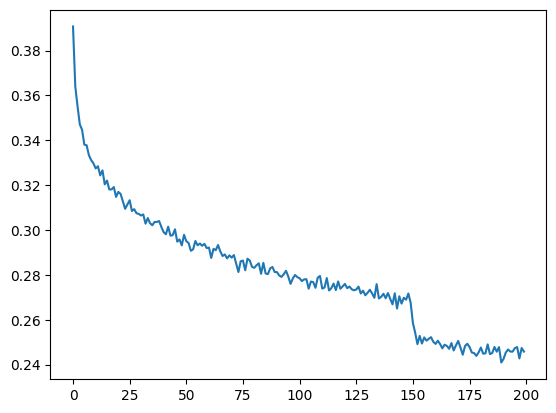

In [34]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [40]:
for layer in model.layers:
    layer.training = False

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst)
    }[split]
    
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.7690253257751465
val 1.9936308860778809


In [ ]:
for i in range(20):
    context = [0] * block_size
    name = []
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        name.append(itos[idx])
        if (idx == 0):
            break
        context = context[1:] + [idx]
    print("".join(name))


In [27]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)


torch.Size([4, 8])
tensor([[ 0,  0, 16, 18,  9, 19,  9, 12],
        [ 0,  0,  0, 12,  5, 12,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 11,  1, 20,  9]])


In [8]:
model.layers[0].out.shape #output of embedding layer

torch.Size([4, 8, 10])

In [9]:
model.layers[1].out.shape #output of flattening layer

torch.Size([4, 80])

In [10]:
model.layers[2].out.shape #output of Linear layer

torch.Size([4, 200])

In [11]:
model.layers[3].out.shape

torch.Size([4, 200])

In [15]:
(torch.randn((4, 5, 80)) @ torch.randn((8*10, 200)) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [ ]:
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(explicit.shape)
(e.view (4, 4, 20) == explicit).all()

In [28]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)
